# Detecting Gravitional Waves Using Topological algorithms

Authors:
* Christian Jaffé Alarcón Acosta - A00832881
* José Andrés Orantes Guillén - A01174130
* Juan José Montes Raygoza - A00834630
* Pedro Fernández Merino - A01733006
* Rubén Darío Castro Terrazas - A00833945



### Import libraries and dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from data.generate_datasets import make_gravitational_waves
from pathlib import Path
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.cm as cm
import gudhi as gd
from sklearn.decomposition import PCA
from nolitsa import dimension, delay
from gtda.plotting import plot_point_cloud
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
import matplotlib.patches as patches
import kmapper as km
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from persim import plot_diagrams
from ripser import ripser

sb.set(style="whitegrid")
plt.rcParams.update(plt.rcParamsDefault) #Permitir Latex

### Motivation


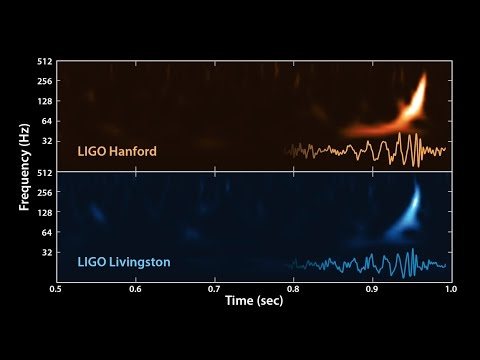

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo("Y3eR49ogsF0", width=600, height=400)
YouTubeVideo("QyDcTbR-kEA", width=600, height=400)

### Generate the data

The data was obtanined from the giotto-tda library: https://github.com/giotto-ai/giotto-tda/blob/master/examples/gravitational_waves_detection.ipynb

In the article, the authors create a synthetic training set as follows: 

* Generate gravitational wave signals that correspond to non-spinning binary black hole mergers
* Generate a noisy time series and embed a gravitational wave signal with probability 0.5 at a random time.

The result is a set of time series of the form

$$ s = g + \epsilon \frac{1}{R}\xi $$

where $g$ is a gravitational wave signal from the reference set, $\xi$ is Gaussian noise, $\epsilon=10^{-19}$ scales the noise amplitude to the signal, and $R \in (0.075, 0.65)$ is a parameter that controls the signal-to-noise-ratio (SNR).

In [3]:

R = 0.65
n_signals = 100
DATA = Path("./data")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 100
Number of timesteps per series: 8692


Plot the data (gravitational waves)

In [4]:
# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()

In [5]:
ts_signal.shape

(8192,)

In [6]:

#initial_segment = ts_signal[:3000]  # Adjust the range according to your data
#threshold = max(abs(initial_segment)) * 1.1  # Slightly higher than the max of the initial part

# Find the index where the signal first exceeds the threshold
#indices = np.where(abs(ts_signal) > threshold)[0]

# Check if indices is empty
#if indices.size > 0:
    #cut_off_index = indices[0]
    #truncated_signal = ts_signal[:cut_off_index]
#else:
    #print("No points exceed the threshold")
    #truncated_signal = ts_signal  # No truncation if the threshold is not exceeded

#ts_signal =  truncated_signal


In [7]:
fig2 = make_subplots(rows=1, cols=1)

fig2.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=1,
)
fig2.show()

### Encaje de Takens

#### Parámetros óptimos de $\tau$ y $d$

* $\tau$: tiempo de retardo
* $d$: dimensión 

In [8]:
ts_noise.shape #dimension de los datos con ruido
max_parameters =  int(round(np.sqrt(ts_noise.shape[0]),0))
max_parameters

93

In [9]:
def find_optimal_delay(x, maxtau):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)
    return int(np.where(diffmi > 0)[0][0]) #returns the first element in which the difference is greater than 0. It means that gives you the local optimal
    #print(np.where(diffmi > 0))

In [10]:
tau_ts_noise  = find_optimal_delay(ts_noise,maxtau=max_parameters) #ejemplo
tau_ts_signal  = find_optimal_delay(ts_signal,maxtau=max_parameters) #ejemplo
print(f'El óptimo local para los datos con ruido es : {tau_ts_noise}')
print(f'El óptimo local para los datos sin ruido es : {tau_ts_signal}')

El óptimo local para los datos con ruido es : 1
El óptimo local para los datos sin ruido es : 15


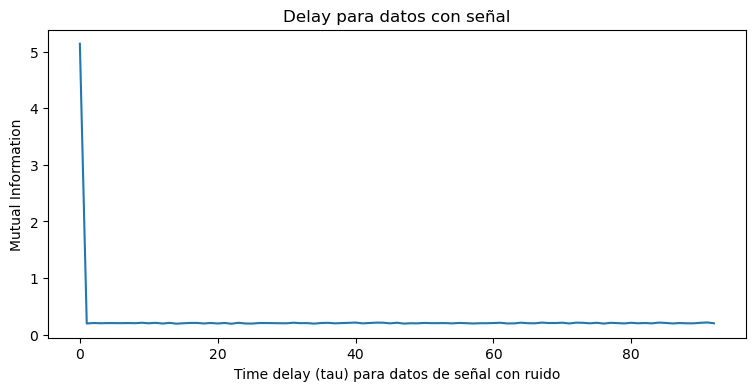

In [11]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau) para datos de señal con ruido')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(ts_noise, maxtau=max_parameters))
plt.title("Delay para datos con señal")
plt.show()

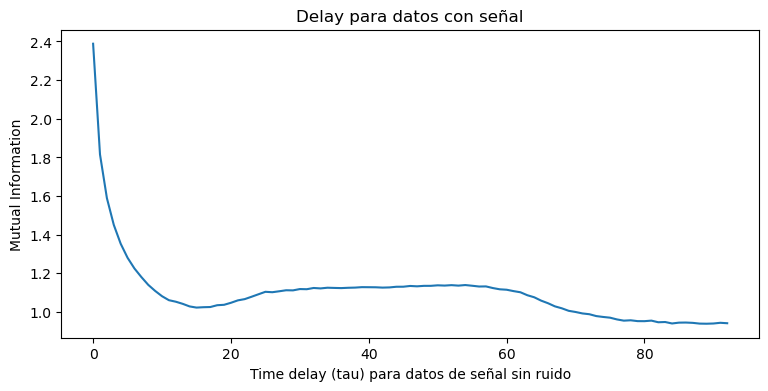

In [12]:
#sin ruido
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau) para datos de señal sin ruido')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(ts_signal, maxtau=max_parameters))
plt.title("Delay para datos con señal")
plt.show()

In [13]:
def find_optimal_dimension(y,tau):
    dim =  np.arange(1,10)
    f1, f2, f3 = dimension.fnn(y, tau=tau, dim=dim)
    diff_f1 = np.diff(f1)
    #print(f1)
    optimal_d = int(np.where(diff_f1 == 0)[0][0]) 

    #changeOf_diff_f1 = np.diff(diff_f1) 
    #optimal_dimension = np.argmax(changeOf_diff_f1) + 2
    return optimal_d


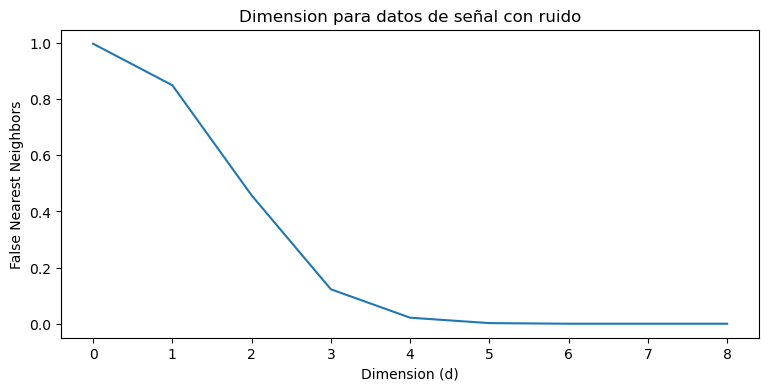

d:  6


In [14]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(ts_noise, tau=tau_ts_noise, dim=dim) #Ejemplo

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors')
plt.title("Dimension para datos de señal con ruido")
plt.plot(f1)
plt.show()
print("d: ",find_optimal_dimension(ts_noise,tau_ts_noise))

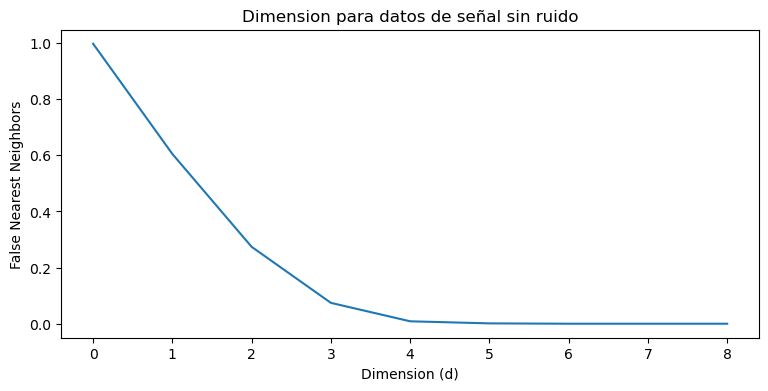

d:  6


In [15]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(ts_signal, tau=tau_ts_signal, dim=dim) #Ejemplo

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors')
plt.title("Dimension para datos de señal sin ruido")
plt.plot(f1)
plt.show()
print("d: ",find_optimal_dimension(ts_noise,tau_ts_noise))

Vamos a elegir la dimension 3.

### Aplicar el Encaje

In [16]:
#Estandarizar datos
from sklearn.preprocessing import StandardScaler

scaler =  StandardScaler()
#scaler.fit(ts_noise.reshape(-1,1))
ts_noise_scaled = scaler.fit_transform(ts_noise.reshape(-1,1))
ts_noise_scaled.shape

(8692, 1)

In [17]:
ts_signal_scaled = scaler.fit_transform(ts_signal.reshape(-1,1))
ts_signal_scaled.shape

(8192, 1)

In [18]:
our_stride = 15
dim =  3

#con ruido
embedder_noise = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay=tau_ts_noise, dimension=2, stride=our_stride
)

y_embedded_noise = embedder_noise.fit_transform(ts_noise_scaled)

In [19]:
#sin ruido
embedder_signal = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay= tau_ts_signal, dimension=2, stride=our_stride
)

y_embedded_signal = embedder_signal.fit_transform(ts_signal_scaled)

In [20]:
y_embedded_noise.shape

(580, 2)

In [21]:
y_embedded_signal.shape

(546, 2)

In [22]:
plot_point_cloud(y_embedded_noise)

In [23]:
ts_signal.shape

(8192,)

In [24]:
plot_point_cloud(y_embedded_signal)

### Analisis de persistencia

In [25]:
result_noise = ripser(y_embedded_noise,maxdim=2)
diagrams_noise = result_noise['dgms']
diagrams_noise

[array([[0.        , 0.00748293],
        [0.        , 0.00806565],
        [0.        , 0.01246825],
        ...,
        [0.        , 0.76133698],
        [0.        , 0.88642013],
        [0.        ,        inf]]),
 array([[0.91742921, 1.20562744],
        [0.77672112, 0.98497289],
        [0.64568806, 0.69158739],
        [0.5990752 , 0.68077677],
        [0.59284991, 0.74079525],
        [0.591793  , 0.65421748],
        [0.49964824, 0.67376661],
        [0.48590314, 0.51175177],
        [0.44485903, 0.55498838],
        [0.43355805, 0.45028782],
        [0.43281925, 0.54013854],
        [0.40624535, 0.40906206],
        [0.39529604, 0.61702257],
        [0.38118926, 0.55004269],
        [0.37567368, 0.45280635],
        [0.37070516, 0.38084972],
        [0.34921739, 0.3575767 ],
        [0.33863276, 0.36754465],
        [0.3368158 , 0.34900352],
        [0.3333436 , 0.33958206],
        [0.33092618, 0.33621001],
        [0.3204999 , 0.3247444 ],
        [0.31584245, 0.37679666],

In [26]:
dmg1_noise=diagrams_noise[1] #datos de B_1
huecos_noise = pd.DataFrame(dmg1_noise, columns=['Birth', 'Death'])
huecos_noise['Life'] = huecos_noise['Death'] - huecos_noise['Birth']
huecos_noise = huecos_noise.sort_values(by='Life', ascending=False)
index =pd.Series(range(len(huecos_noise.index))) #index
huecos_noise['huecos_noise'] = index
huecos_noise.head(10)

,Birth,Death,Life,huecos_noise
0,0.917429,1.205627,0.288198,0
12,0.395296,0.617023,0.221727,12
51,0.223499,0.433822,0.210323,51
1,0.776721,0.984973,0.208252,1
117,0.137867,0.321880,0.184013,117
6,0.499648,0.673767,0.174118,6
13,0.381189,0.550043,0.168853,13
69,0.194070,0.362059,0.167989,69
81,0.181587,0.329953,0.148367,81
4,0.592850,0.740795,0.147945,4


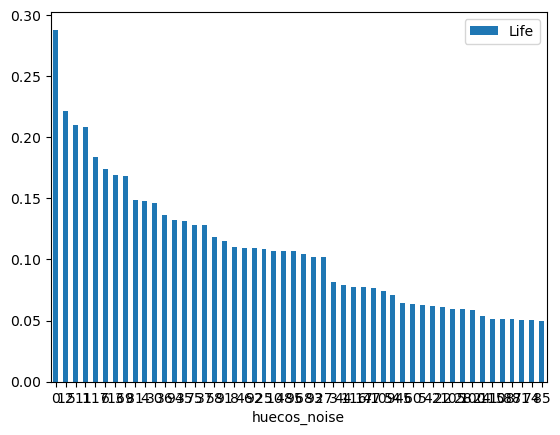

In [27]:
huecos_noise_top10 = huecos_noise.iloc[:50,:]
huecos_noise_top10.plot.bar(x='huecos_noise', y='Life', rot=0) #plot la persistencia de los huecos de la señal con ruido
plt.show()

In [28]:
result_signal = ripser(y_embedded_signal,maxdim=2)
diagrams_signal = result_signal['dgms']
diagrams_signal

[array([[0.00000000e+00, 6.35674733e-05],
        [0.00000000e+00, 1.07634092e-04],
        [0.00000000e+00, 1.13622227e-04],
        ...,
        [0.00000000e+00, 2.15510726e+00],
        [0.00000000e+00, 3.29977059e+00],
        [0.00000000e+00,            inf]]),
 array([[1.09809685e+00, 1.24532855e+00],
        [9.42825198e-01, 1.08490932e+00],
        [8.96169066e-01, 9.41830873e-01],
        [8.71299148e-01, 8.78018260e-01],
        [8.28583062e-01, 9.19075727e-01],
        [7.87341058e-01, 9.37600613e-01],
        [7.13350356e-01, 7.41073430e-01],
        [6.76149845e-01, 8.29218149e-01],
        [6.56170130e-01, 9.34301913e-01],
        [6.51273608e-01, 7.22888947e-01],
        [6.50627375e-01, 7.28040934e-01],
        [6.50341094e-01, 9.30899322e-01],
        [6.44978523e-01, 1.16171348e+00],
        [6.41169429e-01, 6.93152010e-01],
        [6.41022027e-01, 6.52189910e-01],
        [6.03639781e-01, 9.90558624e-01],
        [5.99241972e-01, 8.95464540e-01],
        [5.51906407

In [35]:
y_embedded_signal.shape

(546, 2)

In [29]:
dmg1_signal = diagrams_signal[1] #datos de B_1
huecos_signal = pd.DataFrame(dmg1_signal, columns=['Birth', 'Death'])
huecos_signal['Life'] = huecos_signal['Death'] - huecos_signal['Birth']
huecos_signal = huecos_signal.sort_values(by='Life', ascending=False)
index =pd.Series(range(len(huecos_signal.index))) #index
huecos_signal['huecos_signal'] = index
huecos_signal.head(10)

,Birth,Death,Life,huecos_signal
12,0.644979,1.161713,0.516735,12
15,0.603640,0.990559,0.386919,15
16,0.599242,0.895465,0.296223,16
11,0.650341,0.930899,0.280558,11
8,0.656170,0.934302,0.278132,8
19,0.518660,0.693034,0.174374,19
7,0.676150,0.829218,0.153068,7
5,0.787341,0.937601,0.150260,5
18,0.523069,0.672890,0.149821,18
0,1.098097,1.245329,0.147232,0


In [30]:
lifetime_signal = sorted([lifetime[1] - lifetime[0] for lifetime in dmg1_signal],reverse=True)   
lifetime_signal

[0.5167349576950073,
 0.386918842792511,
 0.2962225675582886,
 0.2805582284927368,
 0.27813178300857544,
 0.17437416315078735,
 0.15306830406188965,
 0.15025955438613892,
 0.1498207449913025,
 0.14723169803619385,
 0.14208412170410156,
 0.10733214020729065,
 0.09049266576766968,
 0.07837662100791931,
 0.07741355895996094,
 0.07161533832550049,
 0.0674239993095398,
 0.05946442484855652,
 0.051982581615448,
 0.045888662338256836,
 0.0456618070602417,
 0.04263952374458313,
 0.038668274879455566,
 0.036603838205337524,
 0.03441423177719116,
 0.028032124042510986,
 0.027723073959350586,
 0.02213156223297119,
 0.021652668714523315,
 0.01116788387298584,
 0.010567843914031982,
 0.006719112396240234,
 0.0054582953453063965,
 0.0015324072446674109,
 0.001321939518675208,
 0.0012785756262019277,
 0.001230122521519661,
 0.0011848205467686057,
 0.001136253122240305,
 0.0010658177779987454,
 0.0009680282091721892,
 0.0009472225792706013,
 0.0009066482307389379,
 0.000870394054800272,
 0.00085244234

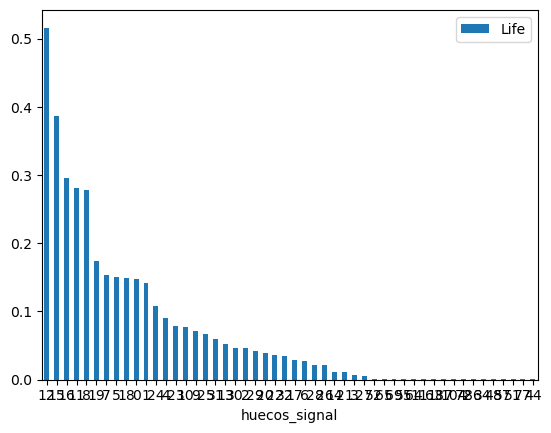

In [31]:
huecos_signal_top20 = huecos_signal.iloc[:50,:]
huecos_signal_top20.plot.bar(x='huecos_signal', y='Life', rot=0) #plot la persistencia de los huecos de la señal con ruido
plt.show()

In [32]:
#skeletonCirc_noise = gd.RipsComplex(points=y_embedded_noise, max_edge_length = 2)
#Rips_simplex_tree_Circ_noise = skeletonCirc_noise.create_simplex_tree(max_dimension = 2)
#Barcodes_Rips_Circ_noise = Rips_simplex_tree_Circ_noise.persistence()
#gd.plot_persistence_diagram(Barcodes_Rips_Circ_noise);
#plt.title(f'Persistence Diagram for signal with noise')
#plt.show()    

In [ ]:
#diag_inf = Rips_simplex_tree_Circ_noise.persistence(min_persistence=0)
#gd.plot_persistence_barcode(diag_inf);
#plt.title(f'Persistence of Barcodes for noise')
#plt.show()

In [ ]:
#skeletonCirc_signal = gd.RipsComplex(points=y_embedded_signal, max_edge_length = 2)
#Rips_simplex_tree_Circ_signal = skeletonCirc_signal.create_simplex_tree(max_dimension = 2)
#Barcodes_Rips_Circ_signal = Rips_simplex_tree_Circ_signal.persistence()
#gd.plot_persistence_diagram(Barcodes_Rips_Circ_signal);
#plt.title(f'Persistence Diagram for signal with no noise')
#plt.show()    

In [ ]:
#diag_inf = Rips_simplex_tree_Circ_signal.persistence(min_persistence=0)
#gd.plot_persistence_barcode(diag_inf);
#plt.title(f'Persistence of Barcodes for signal')
#plt.show()

In [ ]:
#barcodes
#simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
#Notemos con esta paquetería se queda con lo más significativo si cambiamos la persistencia
#diag0 = simplex_tree.persistence(min_persistence=0)
#gudhi.plot_persistence_barcode(diag0)
#plt.show()

### Generar vectores para 10 señales 

In [111]:
import random

def generar_señales_(n_of_signals):

    scaler =  StandardScaler()
    n_signals = 100
    signals = []
    for i in range(n_of_signals):
        R = random.uniform(0.075,0.65)
        DATA = Path("./data")
        noisy_signals, gw_signals, labels = make_gravitational_waves(
            path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
        )

        # get the index corresponding to the first pure noise time series
        background_idx = np.argmin(labels)
        # get the index corresponding to the first noise + gravitational wave time series
        signal_idx = np.argmax(labels)

        ts_noise = noisy_signals[background_idx]
        ts_background = noisy_signals[signal_idx]
        ts_signal = gw_signals[signal_idx]


        ts_noise_scaled = scaler.fit_transform(ts_noise.reshape(-1,1))
        ts_signal_scaled = scaler.fit_transform(ts_signal.reshape(-1,1))
        
        #con ruido
        embedder_noise = SingleTakensEmbedding(
            parameters_type="search", n_jobs=6, time_delay= 90, dimension=90, stride=15
        )

        embedder_signal = SingleTakensEmbedding(
            parameters_type="search", n_jobs=6, time_delay= 90, dimension=90, stride=15
        )

        y_embedded_noise = embedder_noise.fit_transform(ts_noise_scaled)
        y_embedded_signal = embedder_signal.fit_transform(ts_signal_scaled)

        #analisis de persistencia con ruido
        result_noise = ripser(y_embedded_noise,maxdim=2)
        diagrams_noise = result_noise['dgms']
        dmg1_noise = diagrams_noise[1] #datos de B_1

        lifetime_b1_noise = sorted([lifetime[1] - lifetime[0] for lifetime in dmg1_noise],reverse=True)
        #lifetime_b1_noise.append("noise")

        #analisis de persistencia sin ruido
        result_signal = ripser(y_embedded_signal,maxdim=2)
        diagrams_signal = result_signal['dgms']
        dmg1_signal = diagrams_signal[1] #datos de B_1

        lifetime_b1_signal = sorted([lifetime[1] - lifetime[0] for lifetime in dmg1_signal],reverse=True)
        #lifetime_b1_signal.append("signal")

        signals.append(lifetime_b1_noise)#Agregar el del ruido  
        signals.append(lifetime_b1_signal)  #Agregar la señal

    

    #encontrar la señal que tiene menos datos
    min_data = len(signals[0]) #primer punto
    for signal in signals:
        if len(signal) < min_data:
            min_data = len(signal)
    
    for i in range(len(signals)):
        signals[i] = signals[i][:min_data]
    
    counter = 1
    #identifar la señal como la ruidosa o limpia, esto se hace en base al orden en la que se hizo el append al final del ciclo for de arriba
    for i in range(1,len(signals)+ 1):
        if i % 2 == 1:
            signals[i-1].append("noise")
        else:
           signals[i-1].append("signal") 



    return signals
    

In [112]:
señales_sinteticas = generar_señales_(10)

In [113]:
for i in range(len(señales_sinteticas)):
    print(len(señales_sinteticas[i]))

267
267
267
267
267
267
267
267
267
267
267
267
267
267
267
267
267
267
267
267


### Mapper

In [114]:
señales_sinteticas[-1][-1]

'signal'

In [126]:
datos = pd.DataFrame(señales_sinteticas)
new_columns =  list(datos.columns)
new_columns[-1] = "tipo_señal"
datos.columns =new_columns
datos

,0,1,2,3,4,5,6,7,8,9,...,257,258,259,260,261,262,263,264,265,tipo_señal
0,0.514199,0.409459,0.394276,0.363618,0.357647,0.348844,0.345318,0.339773,0.336426,0.326022,...,0.074605,0.073840,0.073721,0.073699,0.073450,0.071382,0.069684,0.069624,0.069086,noise
1,0.652460,0.588534,0.562602,0.541028,0.433035,0.373817,0.350163,0.316575,0.302363,0.283183,...,0.000107,0.000103,0.000102,0.000097,0.000096,0.000094,0.000093,0.000091,0.000089,signal
2,0.538595,0.488475,0.474951,0.448931,0.446486,0.437666,0.424733,0.409473,0.405832,0.395841,...,0.112645,0.112057,0.111858,0.111139,0.110316,0.110301,0.109731,0.109675,0.109649,noise
3,0.652460,0.588534,0.562602,0.541028,0.433035,0.373817,0.350163,0.316575,0.302363,0.283183,...,0.000107,0.000103,0.000102,0.000097,0.000096,0.000094,0.000093,0.000091,0.000089,signal
4,0.551840,0.551150,0.505077,0.464592,0.459235,0.447146,0.421757,0.411559,0.408812,0.408168,...,0.114646,0.112689,0.112688,0.111997,0.111946,0.111841,0.111788,0.110634,0.110403,noise
5,1.510112,1.259898,1.249885,1.244666,1.215192,0.882461,0.844815,0.762051,0.749720,0.683436,...,0.000024,0.000024,0.000016,0.000015,0.000007,0.000006,0.000003,0.000003,0.000001,signal
6,0.497401,0.434739,0.426587,0.426178,0.419486,0.412677,0.402889,0.394151,0.386302,0.377750,...,0.106568,0.104805,0.104363,0.103053,0.101740,0.101539,0.100243,0.099881,0.099737,noise
7,0.652460,0.588534,0.562602,0.541028,0.433035,0.373817,0.350163,0.316575,0.302363,0.283183,...,0.000107,0.000103,0.000102,0.000097,0.000096,0.000094,0.000093,0.000091,0.000089,signal
8,0.460112,0.436315,0.425963,0.403547,0.401751,0.400266,0.399003,0.392004,0.390693,0.386101,...,0.112350,0.111559,0.111363,0.110951,0.110905,0.110875,0.110601,0.110518,0.109997,noise
9,0.652460,0.588534,0.562602,0.541028,0.433035,0.373817,0.350163,0.316575,0.302363,0.283183,...,0.000107,0.000103,0.000102,0.000097,0.000096,0.000094,0.000093,0.000091,0.000089,signal


### Guardar los datos

In [128]:
datos.to_csv("señales_b1.csv",index=False)